In [69]:
import pandas as pd
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from sklearn.cross_validation import train_test_split
from sklearn import cross_validation
from sklearn import metrics
from sklearn import preprocessing
from sklearn.grid_search import GridSearchCV
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import decomposition
import random
from scipy import stats

In [7]:
data = pd.read_csv("C:\Datasets\processed.cleveland.data.txt",header=None,na_values=["?"])
data.shape

(303, 14)

In [8]:
data.rename(columns={0: 'age', 1: 'sex', 2: 'cp', 3: 'trestbps', 4: 'chol', 
                      5: 'fbs', 6: 'restecg', 7: 'thalach', 8: 'exang', 9: 'oldpeak', 
                      10: 'slope', 11: 'ca', 12: 'thal', 13: 'num'}, inplace=True)

In [9]:
data.head(10)
#Note: some variables are categorical, where the levels are represented by numeric integers

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2,3,3
7,57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1,7,2
9,53,1,4,140,203,1,2,155,1,3.1,3,0,7,1


In [10]:
data.describe(include="all").T
#We see that "ca" has 4 missing values and "thal" has 2 missing values.

,count,mean,std,min,25%,50%,75%,max
age,303,54.438944,9.038662,29,48.0,56.0,61.0,77.0
sex,303,0.679868,0.467299,0,0.0,1.0,1.0,1.0
cp,303,3.158416,0.960126,1,3.0,3.0,4.0,4.0
trestbps,303,131.689769,17.599748,94,120.0,130.0,140.0,200.0
chol,303,246.693069,51.776918,126,211.0,241.0,275.0,564.0
fbs,303,0.148515,0.356198,0,0.0,0.0,0.0,1.0
restecg,303,0.990099,0.994971,0,0.0,1.0,2.0,2.0
thalach,303,149.607261,22.875003,71,133.5,153.0,166.0,202.0
exang,303,0.326733,0.469794,0,0.0,0.0,1.0,1.0
oldpeak,303,1.039604,1.161075,0,0.0,0.8,1.6,6.2


In [11]:
#These are the rows where there are missing values for the "ca" variable.
data[data.ca.isnull()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7,1
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3,0


In [12]:
#These are the rows where there are missing values for the "thal" variable.
data[data.thal.isnull()]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
87,53,0,3,128,216,0,2,115,0,0,1,0,NaN,0
266,52,1,4,128,204,1,0,156,1,1,2,0,NaN,2


The missing values will be replaced by the mean of each of the two variables. However, we will perform this step in a sightly more intelligent manner than simply replacing the missing value with the mean. Since there are 5 classes in our data, we will compute the mean value for the variables "ca" and "thal", for each of the 5 classes. Then, the missing values will be replaced by the mean value that corresponds to that class label for that particular observation.

In [13]:
data.groupby("num").describe(include="all")
#"Num" is our class variable. this gives us the mean of each of our variables, broken down by the 5 classes.

age          ca        chol          cp       exang  \
num                                                                     
0   count  164.000000  161.000000  164.000000  164.000000  164.000000   
    mean    52.585366    0.273292  242.640244    2.792683    0.140244   
    std      9.511957    0.632333   53.456580    0.916620    0.348303   
    min     29.000000    0.000000  126.000000    1.000000    0.000000   
    25%     44.750000    0.000000  208.750000    2.000000    0.000000   
    50%     52.000000    0.000000  234.500000    3.000000    0.000000   
    75%     59.000000    0.000000  267.250000    3.000000    0.000000   
    max     76.000000    3.000000  564.000000    4.000000    1.000000   
1   count   55.000000   54.000000   55.000000   55.000000   55.000000   
    mean    55.381818    0.740741  249.109091    3.345455    0.454545   
    std      8.001136    0.872757   40.751129    1.004032    0.502519   
    min     35.000000    0.000000  149.000000    1.000000    0.000000   
    25%     50.500000    0.000000  226.000000    3.000000    0.000000   
    50%     57.000000    1.000000  249.000000    4.000000    0.000000   
    75%     60.500000    1.000000  275.500000    4.000000    1.000000   
    max     70.000000    3.000000  335.000000    4.000000    1.000000   
2   count   36.000000   36.000000   36.000000   36.000000   36.000000   
    mean    58.027778    1.222222  259.277778    3.750000    0.611111   
    std      7.220946    0.959497   53.745225    0.649175    0.494413   
    min     42.000000    0.000000  169.000000    1.000000    0.000000   
    25%     55.750000    0.750000  223.250000    4.000000    0.000000   
    50%     59.000000    1.000000  254.000000    4.000000    1.000000   
    75%     62.250000    2.000000  293.250000    4.000000    1.000000   
    max     69.000000    3.000000  409.000000    4.000000    1.000000   
3   count   35.000000   35.000000   35.000000   35.000000   35.000000   
    mean    56.000000    1.457143  246.457143    3.771429    0.657143   
    std      7.780065    1.010034   51.741065    0.546955    0.481594   
    min     39.000000    0.000000  131.000000    2.000000    0.000000   
    25%     51.500000    1.000000  209.000000    4.000000    0.000000   
    50%     56.000000    2.000000  256.000000    4.000000    1.000000   
    75%     62.000000    2.000000  281.500000    4.000000    1.000000   
    max     70.000000    3.000000  353.000000    4.000000    1.000000   
4   count   13.000000   13.000000   13.000000   13.000000   13.000000   
    mean    59.692308    1.692308  253.384615    3.692308    0.461538   
    std      9.419701    1.250641   66.287931    0.854850    0.518875   
    min     38.000000    0.000000  166.000000    1.000000    0.000000   
    25%     57.000000    1.000000  212.000000    4.000000    0.000000   
    50%     60.000000    2.000000  231.000000    4.000000    0.000000   
    75%     64.000000    3.000000  289.000000    4.000000    1.000000   
    max     77.000000    3.000000  407.000000    4.000000    1.000000   

                  fbs     oldpeak     restecg         sex       slope  \
num                                                                     
0   count  164.000000  164.000000  164.000000  164.000000  164.000000   
    mean     0.140244    0.586585    0.835366    0.560976    1.408537   
    std      0.348303    0.781734    0.986270    0.497788    0.594598   
    min      0.000000    0.000000    0.000000    0.000000    1.000000   
    25%      0.000000    0.000000    0.000000    0.000000    1.000000   
    50%      0.000000    0.200000    0.000000    1.000000    1.000000   
    75%      0.000000    1.025000    2.000000    1.000000    2.000000   
    max      1.000000    4.200000    2.000000    1.000000    3.000000   
1   count   55.000000   55.000000   55.000000   55.000000   55.000000   
    mean     0.072727    1.005455    1.163636    0.836364    1.636364   
    std      0.262082    0.993389    0.995613    0.373355    0.556565   
  

In [14]:
#break up the data into 5 subsets, by class label.
#this will make it easier to replace the missing values by the mean value for a particular class label
data_num0 = data[data.num==0]
data_num1 = data[data.num==1]
data_num2 = data[data.num==2]
data_num3 = data[data.num==3]
data_num4 = data[data.num==4]

The variable "ca" is the number of major vessels colored by fluoroscopy. Its values are numeric integers in the range of [0,3].

All of the missing values for the "ca" variable are have a class label of either 0 or 1.

In [15]:
ca_num0=round(data_num0.ca.mean())
ca_num0
#the average value for "ca" when the class label is 0, is 0.27329

0.0

In [16]:
#here we replace those missing values for the "ca" variable that have a class label of 0, 
#with the mean "ca" value for that class label
data_num0.ca.fillna(ca_num0, axis=0, inplace=True)

C:\Users\Thavaselvi\Anaconda\lib\site-packages\pandas\core\generic.py:2602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [17]:
#here we do the same thing for the missing "ca" values which have a class label of 1.
ca_num1=round(data_num1.ca.mean())
ca_num1

1.0

In [18]:
#replace missing "ca" values which have a class label of 1
data_num1.ca.fillna(ca_num1, axis=0, inplace=True)

The variable "thal" refers to a Thalium Stress Test that was performed on each of the patients. The three values for this variable are categorical, and are represented by the integers 3, 6, and 7. (3=Normal; 6=Fixed Defect; and 7=Reversible Defect).

All of the missing values for the "thal" variable are have a class label of either 0 or 2.

In [19]:
#for the class label 0, the variable "thal" has a mean of 3.7, 
#Out of the three possible values for the "thal" variable, 3.7 is closest to 3.
thal_num0=data_num0.thal.mean()
int(thal_num0)

3

In [20]:
#here we replace the missing "thal" values which have a class label of 0.
data_num0.thal.fillna(int(thal_num0), axis=0, inplace=True)

In [21]:
thal_num2=data_num2.thal.mean()
int(thal_num2)

6

In [22]:
#here we replace the missing "thal" values which have a class label of 2.
data_num2.thal.fillna(int(thal_num2), axis=0, inplace=True)

All missing values are now replaced by their mean value, corresponding to their particular class label.
We can now restack each of the dataX dataframes into one whole dataframe (as they were originally).

In [23]:
frames = [data_num0, data_num1, data_num2, data_num3, data_num4]
data2 = pd.concat(frames)

In [24]:
data2=data2.sort_index()

In [25]:
data2.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
5,56,1,2,120,236,0,0,178,0,0.8,1,0,3,0
6,62,0,4,140,268,0,2,160,0,3.6,3,2,3,3
7,57,0,4,120,354,0,0,163,1,0.6,1,0,3,0
8,63,1,4,130,254,0,2,147,0,1.4,2,1,7,2
9,53,1,4,140,203,1,2,155,1,3.1,3,0,7,1


In [26]:
data2.shape

(303, 14)

In [27]:
data2.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
age,303,54.438944,9.038662,29,48.0,56.0,61.0,77.0
sex,303,0.679868,0.467299,0,0.0,1.0,1.0,1.0
cp,303,3.158416,0.960126,1,3.0,3.0,4.0,4.0
trestbps,303,131.689769,17.599748,94,120.0,130.0,140.0,200.0
chol,303,246.693069,51.776918,126,211.0,241.0,275.0,564.0
fbs,303,0.148515,0.356198,0,0.0,0.0,0.0,1.0
restecg,303,0.990099,0.994971,0,0.0,1.0,2.0,2.0
thalach,303,149.607261,22.875003,71,133.5,153.0,166.0,202.0
exang,303,0.326733,0.469794,0,0.0,0.0,1.0,1.0
oldpeak,303,1.039604,1.161075,0,0.0,0.8,1.6,6.2


In [28]:
#Changing the target values that are 2, 3 or 4 to 1
data2.num[data2.num==2] = 1
data2.num[data2.num==3] = 1
data2.num[data2.num==4] = 1

C:\Users\Thavaselvi\Anaconda\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Thavaselvi\Anaconda\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Thavaselvi\Anaconda\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [29]:
#cd C:/datasets

In [30]:
#write this datafile to csv for future reference if necessary.
#data2.to_csv("data2.csv",index=False)

In [31]:
data2.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
age,303,54.438944,9.038662,29,48.0,56.0,61.0,77.0
sex,303,0.679868,0.467299,0,0.0,1.0,1.0,1.0
cp,303,3.158416,0.960126,1,3.0,3.0,4.0,4.0
trestbps,303,131.689769,17.599748,94,120.0,130.0,140.0,200.0
chol,303,246.693069,51.776918,126,211.0,241.0,275.0,564.0
fbs,303,0.148515,0.356198,0,0.0,0.0,0.0,1.0
restecg,303,0.990099,0.994971,0,0.0,1.0,2.0,2.0
thalach,303,149.607261,22.875003,71,133.5,153.0,166.0,202.0
exang,303,0.326733,0.469794,0,0.0,0.0,1.0,1.0
oldpeak,303,1.039604,1.161075,0,0.0,0.8,1.6,6.2


Now we can replace the integers that are being used as labels for the categorical variables, with the actual categorical labels.

In [32]:
data2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [33]:
data2.loc[data2.sex == 0, 'sex'] = 'female'
data2.loc[data2.sex == 1, 'sex'] = 'male'
data2.loc[data2.cp == 1, 'cp'] = 'typical_angina'
data2.loc[data2.cp == 2, 'cp'] = 'atypical_angina'
data2.loc[data2.cp == 3, 'cp'] = 'non_anginal_pain'
data2.loc[data2.cp == 4, 'cp'] = 'asymptomatic'
data2.loc[data2.fbs == 0, 'fbs'] = '<=120mg/dl'
data2.loc[data2.fbs == 1, 'fbs'] = '>120mg/dl'
data2.loc[data2.restecg == 0, 'restecg'] = 'normal'
data2.loc[data2.restecg == 1, 'restecg'] = 'STT_wave_abnormality'
data2.loc[data2.restecg == 2, 'restecg'] = 'left_ventricular_hypertrophy'
data2.loc[data2.exang == 0, 'exang'] = 'no'
data2.loc[data2.exang == 1, 'exang'] = 'yes'
data2.loc[data2.slope == 1, 'slope'] = 'upsloping'
data2.loc[data2.slope == 2, 'slope'] = 'flat'
data2.loc[data2.slope == 3, 'slope'] = 'downsloping'
data2.loc[data2.thal == 3, 'thal'] = 'normal'
data2.loc[data2.thal == 6, 'thal'] = 'fixed_defect'
data2.loc[data2.thal == 7, 'thal'] = 'reversable_defect'

In [34]:
data2.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,male,typical_angina,145,233,>120mg/dl,left_ventricular_hypertrophy,150,no,2.3,downsloping,0,fixed_defect,0
1,67,male,asymptomatic,160,286,<=120mg/dl,left_ventricular_hypertrophy,108,yes,1.5,flat,3,normal,1
2,67,male,asymptomatic,120,229,<=120mg/dl,left_ventricular_hypertrophy,129,yes,2.6,flat,2,reversable_defect,1
3,37,male,non_anginal_pain,130,250,<=120mg/dl,normal,187,no,3.5,downsloping,0,normal,0
4,41,female,atypical_angina,130,204,<=120mg/dl,left_ventricular_hypertrophy,172,no,1.4,upsloping,0,normal,0


In [35]:
data2.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,303,NaN,NaN,NaN,54.43894,9.038662,29,48,56,61,77
sex,303,2,male,206,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cp,303,4,asymptomatic,144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trestbps,303,NaN,NaN,NaN,131.6898,17.59975,94,120,130,140,200
chol,303,NaN,NaN,NaN,246.6931,51.77692,126,211,241,275,564
fbs,303,2,<=120mg/dl,258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
restecg,303,3,normal,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thalach,303,NaN,NaN,NaN,149.6073,22.875,71,133.5,153,166,202
exang,303,2,no,204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
oldpeak,303,NaN,NaN,NaN,1.039604,1.161075,0,0,0.8,1.6,6.2


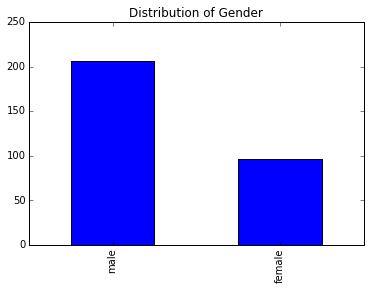

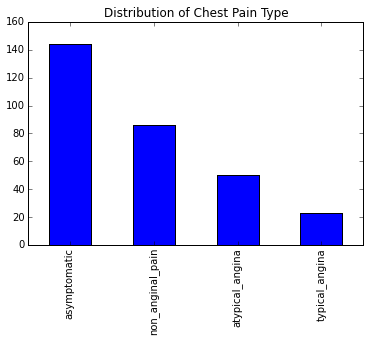

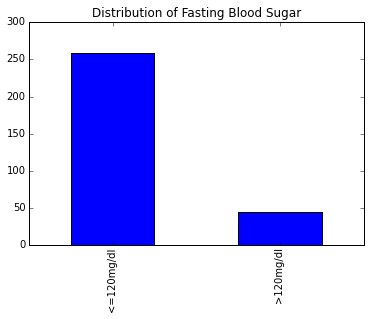

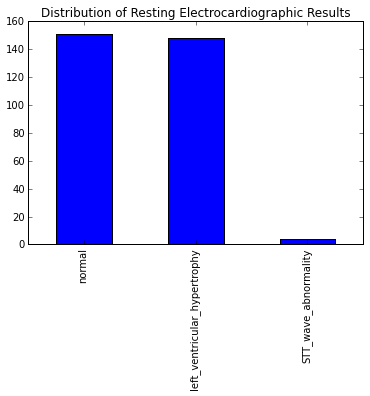

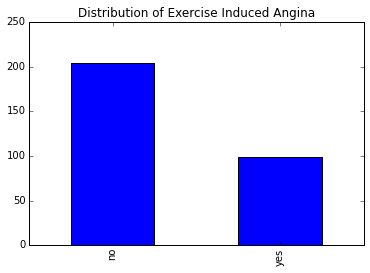

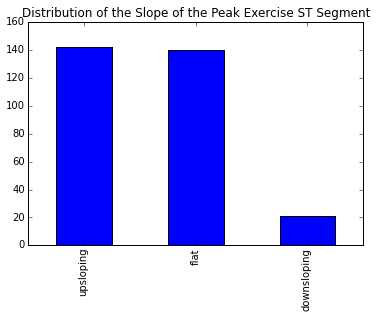

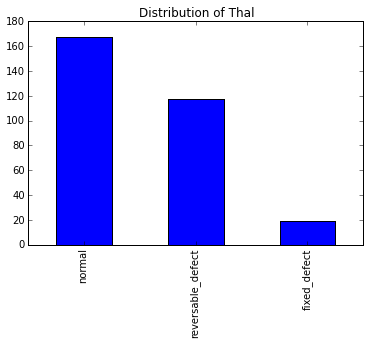

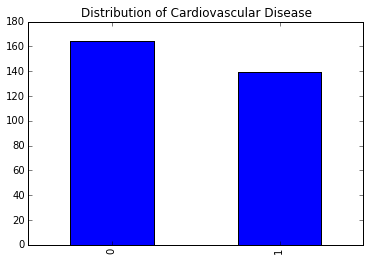

In [36]:
plt.show(data2["sex"].value_counts().plot(kind='bar', title="Distribution of Gender"))
plt.show(data2["cp"].value_counts().plot(kind='bar', title="Distribution of Chest Pain Type"))
plt.show(data2["fbs"].value_counts().plot(kind='bar', title="Distribution of Fasting Blood Sugar"))
plt.show(data2["restecg"].value_counts().plot(kind='bar', title="Distribution of Resting Electrocardiographic Results"))
plt.show(data2["exang"].value_counts().plot(kind='bar', title="Distribution of Exercise Induced Angina"))
plt.show(data2["slope"].value_counts().plot(kind='bar', title="Distribution of the Slope of the Peak Exercise ST Segment"))
plt.show(data2["thal"].value_counts().plot(kind='bar', title="Distribution of Thal"))
plt.show(data2["num"].value_counts().plot(kind='bar', title="Distribution of Cardiovascular Disease"))

In [37]:
#write this datafile (with categorical labels) to csv for future reference if necessary.
#data2.to_csv("data2_cat.csv",index=False)

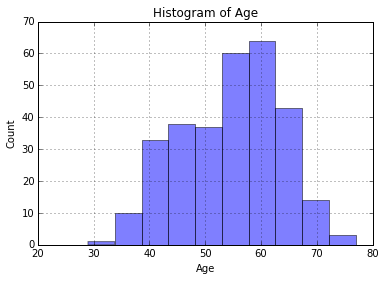

In [38]:
plt.hist(data2["age"], bins=10, alpha=0.5)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Histogram of Age")
plt.grid(True)
plt.show()

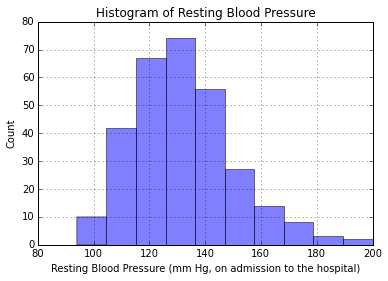

In [39]:
plt.hist(data2["trestbps"], bins=10, alpha=0.5)
plt.xlabel("Resting Blood Pressure (mm Hg, on admission to the hospital)")
plt.ylabel("Count")
plt.title("Histogram of Resting Blood Pressure")
plt.grid(True)
plt.show()

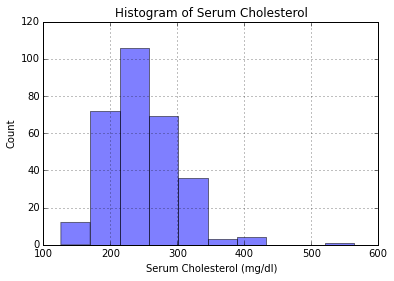

In [40]:
plt.hist(data2["chol"], bins=10, alpha=0.5)
plt.xlabel("Serum Cholesterol (mg/dl)")
plt.ylabel("Count")
plt.title("Histogram of Serum Cholesterol")
plt.grid(True)
plt.show()

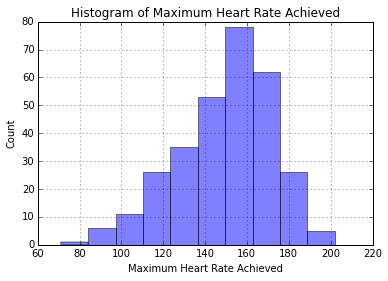

In [41]:
plt.hist(data2["thalach"], bins=10, alpha=0.5)
plt.xlabel("Maximum Heart Rate Achieved")
plt.ylabel("Count")
plt.title("Histogram of Maximum Heart Rate Achieved")
plt.grid(True)
plt.show()

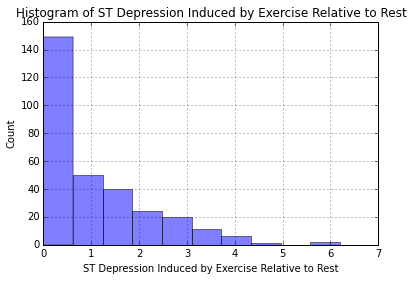

In [42]:
plt.hist(data2["oldpeak"], bins=10, alpha=0.5)
plt.xlabel("ST Depression Induced by Exercise Relative to Rest")
plt.ylabel("Count")
plt.title("Histogram of ST Depression Induced by Exercise Relative to Rest")
plt.grid(True)
plt.show()

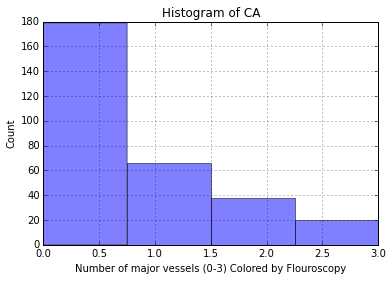

In [43]:
plt.hist(data2["ca"], bins=4, alpha=0.5)
plt.xlabel("Number of major vessels (0-3) Colored by Flouroscopy")
plt.ylabel("Count")
plt.title("Histogram of CA")
plt.grid(True)
plt.show()

In [44]:
data2.groupby("num").describe(include="all")

age          ca        chol                cp exang  \
num                                                                      
0   count   164.000000  164.000000  164.000000               164   164   
    unique         NaN         NaN         NaN                 4     2   
    top            NaN         NaN         NaN  non_anginal_pain    no   
    freq           NaN         NaN         NaN                68   141   
    mean     52.585366    0.268293  242.640244               NaN   NaN   
    std       9.511957    0.627563   53.456580               NaN   NaN   
    min      29.000000    0.000000  126.000000               NaN   NaN   
    25%      44.750000    0.000000  208.750000               NaN   NaN   
    50%      52.000000    0.000000  234.500000               NaN   NaN   
    75%      59.000000    0.000000  267.250000               NaN   NaN   
    max      76.000000    3.000000  564.000000               NaN   NaN   
1   count   139.000000  139.000000  139.000000               139   139   
    unique         NaN         NaN         NaN                 4     2   
    top            NaN         NaN         NaN      asymptomatic   yes   
    freq           NaN         NaN         NaN               105    76   
    mean     56.625899    1.136691  251.474820               NaN   NaN   
    std       7.938416    1.015827   49.486835               NaN   NaN   
    min      35.000000    0.000000  131.000000               NaN   NaN   
    25%      52.000000    0.000000  217.500000               NaN   NaN   
    50%      58.000000    1.000000  249.000000               NaN   NaN   
    75%      62.000000    2.000000  283.500000               NaN   NaN   
    max      77.000000    3.000000  409.000000               NaN   NaN   

                   fbs     oldpeak                       restecg   sex  \
num                                                                      
0   count          164  164.000000                           164   164   
    unique           2         NaN                             3     2   
    top     <=120mg/dl         NaN                        normal  male   
    freq           141         NaN                            95    92   
    mean           NaN    0.586585                           NaN   NaN   
    std            NaN    0.781734                           NaN   NaN   
    min            NaN    0.000000                           NaN   NaN   
    25%            NaN    0.000000                           NaN   NaN   
    50%            NaN    0.200000                           NaN   NaN   
    75%            NaN    1.025000                           NaN   NaN   
    max            NaN    4.200000                           NaN   NaN   
1   count          139  139.000000                           139   139   
    unique           2         NaN                             3     2   
    top     <=120mg/dl         NaN  left_ventricular_hypertrophy  male   
    freq           117         NaN                            80   114   
    mean           NaN    1.574101                           NaN   NaN   
    std            NaN    1.302580                           NaN   NaN   
    min            NaN    0.000000                           NaN   NaN   
    25%            NaN    0.550000                           NaN   NaN   
    50%            NaN    1.400000                           NaN   NaN   
    75%            NaN    2.500000                           NaN   NaN   
    max            NaN    6.200000                           NaN   NaN   

                slope               thal     thalach    trestbps  
num                                                               
0   count         164                164  164.000000  164.000000  
    unique          3                  3         NaN         NaN  
    top     upsloping             normal         NaN         NaN  
    freq          106                130         NaN         NaN  
    mean          NaN                NaN  158.378049  129.25000

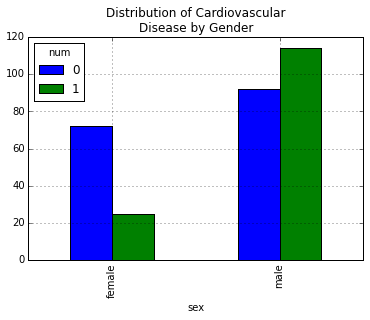

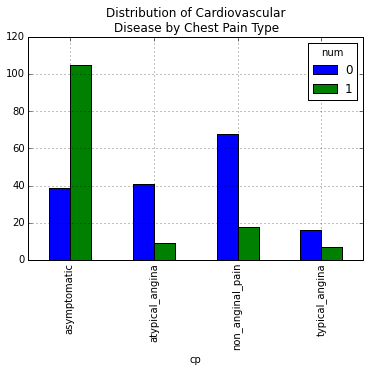

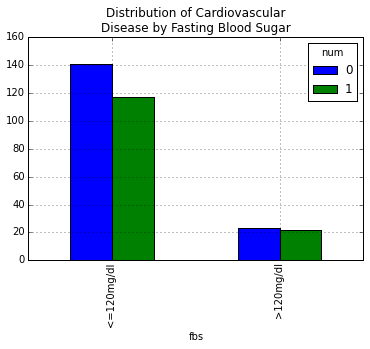

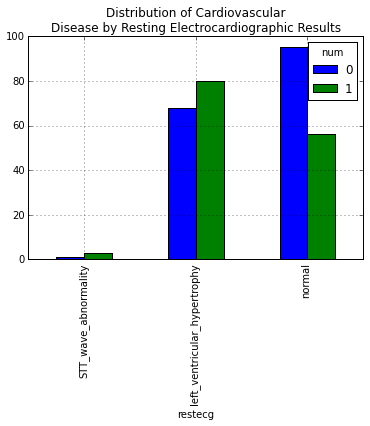

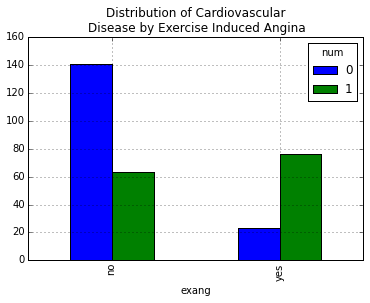

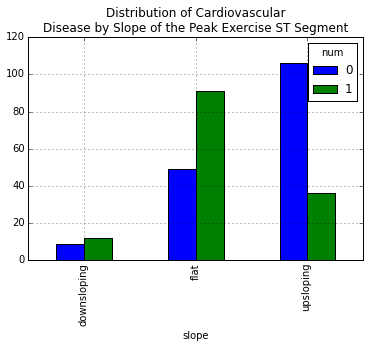

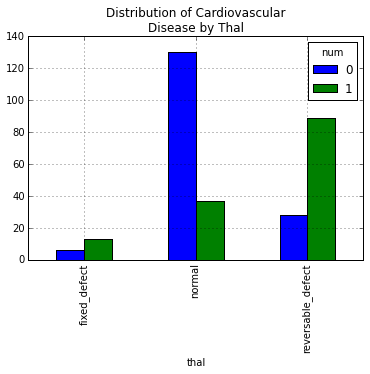

In [45]:
sn = pd.crosstab(data2["sex"], data2["num"])
cn = pd.crosstab(data2["cp"], data2["num"])
fn = pd.crosstab(data2["fbs"], data2["num"])
rn = pd.crosstab(data2["restecg"], data2["num"])
en = pd.crosstab(data2["exang"], data2["num"])
ln = pd.crosstab(data2["slope"], data2["num"])
tn = pd.crosstab(data2["thal"], data2["num"])

sn.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Gender")
cn.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Chest Pain Type")
fn.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Fasting Blood Sugar")
rn.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Resting Electrocardiographic Results")
en.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Exercise Induced Angina")
ln.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Slope of the Peak Exercise ST Segment")
tn.plot(kind="bar",grid = True, title="Distribution of Cardiovascular\nDisease by Thal")


In [46]:
data2.corr() #numeric features only

,age,trestbps,chol,thalach,oldpeak,ca,num
age,1.000000,0.284946,0.208950,-0.393806,0.203805,0.361064,0.223120
trestbps,0.284946,1.000000,0.130120,-0.045351,0.189171,0.097652,0.150825
chol,0.208950,0.130120,1.000000,-0.003432,0.046564,0.123824,0.085164
thalach,-0.393806,-0.045351,-0.003432,1.000000,-0.343085,-0.266890,-0.417167
oldpeak,0.203805,0.189171,0.046564,-0.343085,1.000000,0.298386,0.424510
ca,0.361064,0.097652,0.123824,-0.266890,0.298386,1.000000,0.464167
num,0.223120,0.150825,0.085164,-0.417167,0.424510,0.464167,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x09B2F230>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10D10A30>]], dtype=object)

C:\Users\Thavaselvi\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


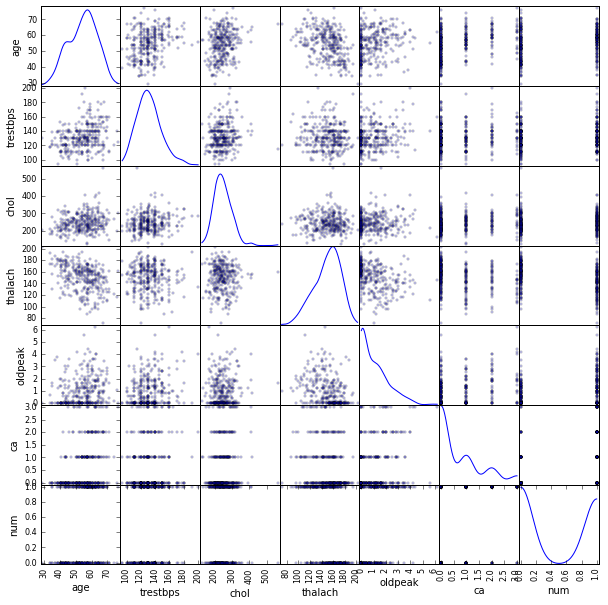

In [47]:
#Scatter matrix (of numeric variables only)
scatter_matrix(data2, alpha=0.2, figsize=(10,10), diagonal='kde')

In [48]:
data2.to_csv("data2_binary.csv",index=False)

In [49]:
#convert categorical variables into dummy variables to see entire correlation matrix

In [50]:
data3=pd.get_dummies(data2)
data3.head().T

,0,1,2,3,4
age,63.0,67.0,67.0,37.0,41.0
trestbps,145.0,160.0,120.0,130.0,130.0
chol,233.0,286.0,229.0,250.0,204.0
thalach,150.0,108.0,129.0,187.0,172.0
oldpeak,2.3,1.5,2.6,3.5,1.4
ca,0.0,3.0,2.0,0.0,0.0
num,0.0,1.0,1.0,0.0,0.0
sex_female,0.0,0.0,0.0,0.0,1.0
sex_male,1.0,1.0,1.0,1.0,0.0
cp_asymptomatic,0.0,1.0,1.0,0.0,0.0


In [51]:
#this will let us see the correlation matrix for all variables
pd.set_option('display.max_columns', None)
data3.corr()

,age,trestbps,chol,thalach,oldpeak,ca,num,sex_female,sex_male,cp_asymptomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,fbs_<=120mg/dl,fbs_>120mg/dl,restecg_STT_wave_abnormality,restecg_left_ventricular_hypertrophy,restecg_normal,exang_no,exang_yes,slope_downsloping,slope_flat,slope_upsloping,thal_fixed_defect,thal_normal,thal_reversable_defect
age,1.000000,0.284946,0.208950,-0.393806,0.203805,0.361064,0.223120,0.097542,-0.097542,0.135337,-0.151684,-0.051714,0.045438,-0.118530,0.118530,0.084097,0.138313,-0.157474,-0.091661,0.091661,0.028487,0.170596,-0.184938,0.056814,-0.130378,0.104902
trestbps,0.284946,1.000000,0.130120,-0.045351,0.189171,0.097652,0.150825,0.064456,-0.064456,0.027710,-0.083234,-0.050127,0.149737,-0.175340,0.175340,0.057995,0.139000,-0.152203,-0.064762,0.064762,0.120930,0.021638,-0.083165,0.070423,-0.138290,0.106210
chol,0.208950,0.130120,1.000000,-0.003432,0.046564,0.123824,0.085164,0.199915,-0.199915,0.070343,-0.016453,-0.033223,-0.053021,-0.009841,0.009841,0.033691,0.166100,-0.173748,-0.061310,0.061310,-0.047652,0.043538,-0.019245,-0.104597,-0.000994,0.053100
thalach,-0.393806,-0.045351,-0.003432,1.000000,-0.343085,-0.266890,-0.417167,0.048663,-0.048663,-0.371989,0.249415,0.159876,0.079683,0.007854,-0.007854,-0.120829,-0.069061,0.096625,0.378103,-0.378103,-0.056191,-0.418573,0.446787,-0.151731,0.283753,-0.214326
oldpeak,0.203805,0.189171,0.046564,-0.343085,1.000000,0.298386,0.424510,-0.102173,0.102173,0.274218,-0.277513,-0.126339,0.086959,-0.005747,0.005747,0.168172,0.094202,-0.132567,-0.288223,0.288223,0.394253,0.310986,-0.511356,0.101558,-0.345261,0.302145
ca,0.361064,0.097652,0.123824,-0.266890,0.298386,1.000000,0.464167,-0.088531,0.088531,0.276473,-0.155775,-0.143956,-0.057923,-0.149329,0.149329,0.041356,0.129841,-0.139248,-0.150961,0.150961,-0.027878,0.168054,-0.153710,0.077881,-0.258610,0.225414
num,0.223120,0.150825,0.085164,-0.417167,0.424510,0.464167,1.000000,-0.276816,0.276816,0.516459,-0.248683,-0.315141,-0.088806,-0.025264,0.025264,0.067605,0.160400,-0.175790,-0.431894,0.431894,0.061710,0.355709,-0.386789,0.117033,-0.527469,0.480582
sex_female,0.097542,0.064456,0.199915,0.048663,-0.102173,-0.088531,-0.276816,1.000000,-1.000000,-0.086398,0.037990,0.117189,-0.089828,0.047862,-0.047862,0.106574,-0.033676,0.009339,0.146201,-0.146201,-0.047986,0.002576,0.021849,-0.148308,0.391676,-0.326284
sex_male,-0.097542,-0.064456,-0.199915,-0.048663,0.102173,0.088531,0.276816,-1.000000,1.000000,0.086398,-0.037990,-0.117189,0.089828,-0.047862,0.047862,-0.106574,0.033676,-0.009339,-0.146201,0.146201,0.047986,-0.002576,-0.021849,0.148308,-0.391676,0.326284
cp_asymptomatic,0.135337,0.027710,0.070343,-0.371989,0.274218,0.276473,0.516459,-0.086398,0.086398,1.000000,-0.423065,-0.599104,-0.272752,0.062929,-0.062929,0.063635,0.114539,-0.129035,-0.464293,0.464293,0.026537,0.231517,-0.244810,0.108231,-0.350336,0.304008


In [45]:
#Splitting up the data into predictor variables and target variable.

In [52]:
data_records = data3[['age','sex_female','sex_male','cp_asymptomatic','cp_atypical_angina','cp_non_anginal_pain','cp_typical_angina','trestbps','chol','fbs_<=120mg/dl','fbs_>120mg/dl','restecg_STT_wave_abnormality','restecg_left_ventricular_hypertrophy','restecg_normal','thalach','exang_no','exang_yes','oldpeak','slope_downsloping','slope_flat','slope_upsloping','ca','thal_fixed_defect','thal_normal','thal_reversable_defect']]
data_target = data3['num']

In [53]:
#Now let's split up the data into train and test sets (for both the predictor variables and target variable)

In [54]:
#removed random state
data_train, data_test, data_target_train, data_target_test = train_test_split(data_records, data_target, test_size=0.20)

print data_train.shape, data_test.shape
print data_test[0:5].T


(242, 25) (61, 25)
[[  55.    61.    63.    56.    50. ]
 [   0.     0.     0.     0.     0. ]
 [   1.     1.     1.     1.     1. ]
 [   0.     0.     1.     0.     0. ]
 [   1.     0.     0.     0.     0. ]
 [   0.     0.     0.     1.     1. ]
 [   0.     1.     0.     0.     0. ]
 [ 130.   134.   140.   130.   140. ]
 [ 262.   234.   187.   256.   233. ]
 [   1.     1.     1.     0.     1. ]
 [   0.     0.     0.     1.     0. ]
 [   0.     0.     0.     0.     0. ]
 [   0.     0.     1.     1.     0. ]
 [   1.     1.     0.     0.     1. ]
 [ 155.   145.   144.   142.   163. ]
 [   1.     1.     0.     0.     1. ]
 [   0.     0.     1.     1.     0. ]
 [   0.     2.6    4.     0.6    0.6]
 [   0.     0.     0.     0.     0. ]
 [   0.     1.     0.     1.     1. ]
 [   1.     0.     1.     0.     0. ]
 [   0.     2.     2.     1.     1. ]
 [   0.     0.     0.     1.     0. ]
 [   1.     1.     0.     0.     0. ]
 [   0.     0.     1.     0.     1. ]]


In [55]:
#Normalizing the data
min_max_scaler = preprocessing.MinMaxScaler().fit(data_train)
data_train_norm = min_max_scaler.transform(data_train)
data_test_norm = min_max_scaler.transform(data_test)

In [56]:
print data_test_norm[0:5].T

[[ 0.55319149  0.68085106  0.72340426  0.57446809  0.44680851]
 [ 0.          0.          0.          0.          0.        ]
 [ 1.          1.          1.          1.          1.        ]
 [ 0.          0.          1.          0.          0.        ]
 [ 1.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          1.        ]
 [ 0.          1.          0.          0.          0.        ]
 [ 0.36734694  0.40816327  0.46938776  0.36734694  0.46938776]
 [ 0.31050228  0.24657534  0.13926941  0.29680365  0.24429224]
 [ 1.          1.          1.          0.          1.        ]
 [ 0.          0.          0.          1.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          1.          1.          0.        ]
 [ 1.          1.          0.          0.          1.        ]
 [ 0.5877193   0.5         0.49122807  0.47368421  0.65789474]
 [ 1.          1.          0.          0.          1.  

In [57]:
#Model Construction and Evaluation

In [59]:
#Grid search using decision tree
dt = tree.DecisionTreeClassifier()

parameters = {
    'criterion': ['entropy','gini'],
    'max_depth': range(1, 21, 1),
    'min_samples_leaf': range(2, 31, 2),
    'min_samples_split': range(2, 21, 2)
}

#changed to 10-fold cross-validation
gs = GridSearchCV(dt, parameters, verbose=1, cv=10)

In [60]:
%time _ = gs.fit(data_train_norm, data_target_train)
gs.best_params_, gs.best_score_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed:    8.1s
[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed:    9.9s
[Parallel(n_jobs=1)]: Done 8450 jobs       | elapsed:   11.7s
[Parallel(n_jobs=1)]: Done 9800 jobs       | elapsed:   13.8s
[Parallel(n_jobs=1)]: Done 11250 jobs       | elapsed:   15.9s
[Parallel(n_

Fitting 10 folds for each of 6000 candidates, totalling 60000 fits
Wall time: 1min 25s


({'criterion': 'entropy',
  'max_depth': 4,
  'min_samples_leaf': 12,
  'min_samples_split': 2},
 0.78512396694214881)

In [61]:
#Grid search using Random Forest
rf = RandomForestClassifier()
rf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [63]:
rfparameters = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': range(5, 51, 5),
    'max_depth': range(1, 21, 2),
    'min_samples_split': range(2, 21, 2)
}

#changed to 10-fold cross-validation
rf_gs = GridSearchCV(rf, rfparameters, verbose=1, cv=10) 

In [64]:
%time _ = rf_gs.fit(data_train_norm, data_target_train)
rf_gs.best_params_, rf_gs.best_score_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    6.7s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:   19.7s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:   29.5s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:   40.8s
[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed:   55.0s
[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done 8450 jobs       | elapsed:  2.5min
[Parallel(n_jobs=1)]: Done 9800 jobs       | elapsed:  3.0min
[Parallel(n_jobs=1)]: Done 11250 jobs       | elapsed:  3.4min
[Parallel(n_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Wall time: 5min 54s


({'criterion': 'entropy',
  'max_depth': 17,
  'min_samples_split': 16,
  'n_estimators': 20},
 0.85537190082644632)

In [65]:
#Grid search using AdaBoost
ab = AdaBoostClassifier()
ab.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [66]:
abparameters = {
    'n_estimators': range(5, 76, 5),
    'learning_rate': np.linspace(0.0001,1,30)
}

ab_gs = GridSearchCV(ab, abparameters, verbose=1, cv=10)

In [67]:
%time _ = ab_gs.fit(data_train_norm, data_target_train)
ab_gs.best_params_, ab_gs.best_score_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:   13.4s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:   23.0s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:   36.6s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:   54.0s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed:  2.0min


Fitting 10 folds for each of 450 candidates, totalling 4500 fits
Wall time: 2min 15s


[Parallel(n_jobs=1)]: Done 4500 out of 4500 | elapsed:  2.3min finished


({'learning_rate': 0.55176896551724142, 'n_estimators': 70},
 0.85123966942148765)

In [68]:
from sklearn.ensemble import ExtraTreesClassifier
ex = ExtraTreesClassifier()
ex.get_params()

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [69]:
exparameters = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': range(5, 51, 5),
    'max_depth': range(1, 21, 2),
    'min_samples_split': range(2, 21, 2)
}

#changed to 10-fold cross-validation
ex_gs = GridSearchCV(ex, exparameters, verbose=1, cv=10)

In [70]:
%time _ = ex_gs.fit(data_train_norm, data_target_train)
ex_gs.best_params_, ex_gs.best_score_

[Parallel(n_jobs=1)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 jobs       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 200 jobs       | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 450 jobs       | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done 800 jobs       | elapsed:   11.5s
[Parallel(n_jobs=1)]: Done 1250 jobs       | elapsed:   17.9s
[Parallel(n_jobs=1)]: Done 1800 jobs       | elapsed:   26.6s
[Parallel(n_jobs=1)]: Done 2450 jobs       | elapsed:   36.6s
[Parallel(n_jobs=1)]: Done 3200 jobs       | elapsed:   49.3s
[Parallel(n_jobs=1)]: Done 4050 jobs       | elapsed:  1.0min
[Parallel(n_jobs=1)]: Done 5000 jobs       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done 6050 jobs       | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done 7200 jobs       | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done 8450 jobs       | elapsed:  2.3min
[Parallel(n_jobs=1)]: Done 9800 jobs       | elapsed:  2.7min
[Parallel(n_jobs=1)]: Done 11250 jobs       | elapsed:  3.0min
[Parallel(n_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Wall time: 5min 26s


({'criterion': 'entropy',
  'max_depth': 3,
  'min_samples_split': 6,
  'n_estimators': 5},
 0.83471074380165289)

In [65]:
#training accuracy on decision tree (with binary class label)
Train_accuracy_dt = []
Test_accuracy_dt = []
Train_clrpt_dt = []
Test_clrpt_dt = []
Train_confmat_dt = []
Test_confmat_dt = []

Train_accuracy_rf = []
Test_accuracy_rf = []
Train_clrpt_rf = []
Test_clrpt_rf = []
Train_confmat_rf = []
Test_confmat_rf = []

Train_accuracy_ab = []
Test_accuracy_ab = []
Train_clrpt_ab = []
Test_clrpt_ab = []
Train_confmat_ab = []
Test_confmat_ab = []

Train_accuracy_ex = []
Test_accuracy_ex = []
Train_clrpt_ex = []
Test_clrpt_ex = []
Train_confmat_ex = []
Test_confmat_ex = []


#change from range(1,20) to range(1,21) so we have an even 20 samples
#removed setting of random seed
for i in range(1,21):
    random.seed(1)
    data_train, data_test, data_target_train, data_target_test = train_test_split(data_records, data_target, test_size=0.20)
    min_max_scaler = preprocessing.MinMaxScaler().fit(data_train)
    data_train_norm = min_max_scaler.transform(data_train)
    data_test_norm = min_max_scaler.transform(data_test)
    # Decision Tree
    dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=12, min_samples_split=2)
    dt.fit(data_train_norm, data_target_train)
    dt_predictions=dt.predict(data_train_norm)
    Train_accuracy_dt.append(metrics.accuracy_score(data_target_train, dt_predictions))
    Train_clrpt_dt.append(metrics.classification_report(data_target_train, dt_predictions))
    Train_confmat_dt.append(metrics.confusion_matrix(data_target_train, dt_predictions))
    # Random Forest
    rf = RandomForestClassifier(criterion='entropy',max_depth=17,min_samples_split=16, n_estimators=20, random_state=11)
    rf.fit(data_train_norm, data_target_train)
    rf_predictions=rf.predict(data_train_norm)
    Train_accuracy_rf.append(metrics.accuracy_score(data_target_train, rf_predictions))
    Train_clrpt_rf.append(metrics.classification_report(data_target_train, rf_predictions))
    Train_confmat_rf.append(metrics.confusion_matrix(data_target_train, rf_predictions))
    # Adaboost
    ab = AdaBoostClassifier(n_estimators=70, learning_rate = 0.55)
    ab.fit(data_train_norm, data_target_train)
    ab_predictions=ab.predict(data_train_norm)
    Train_accuracy_ab.append(metrics.accuracy_score(data_target_train, ab_predictions))
    Train_clrpt_ab.append(metrics.classification_report(data_target_train, ab_predictions))
    Train_confmat_ab.append(metrics.confusion_matrix(data_target_train, ab_predictions))
    # Extra Trees classifier
    ex = ExtraTreesClassifier(criterion='entropy',max_depth=3, min_samples_split=6, n_estimators=5)#, random_state=11)
    ex.fit(data_train_norm, data_target_train)
    ex_predictions=ex.predict(data_train_norm)
    Train_accuracy_ex.append(metrics.accuracy_score(data_target_train, ex_predictions))
    Train_clrpt_ex.append(metrics.classification_report(data_target_train, ex_predictions))
    Train_confmat_ex.append(metrics.confusion_matrix(data_target_train, ex_predictions))
    
    
    # Testing data
    # Decision Tree
    dt_predictions_test=dt.predict(data_test_norm)
    Test_accuracy_dt.append(metrics.accuracy_score(data_target_test, dt_predictions_test))
    Test_clrpt_dt.append(metrics.classification_report(data_target_test, dt_predictions_test))
    Test_confmat_dt.append(metrics.confusion_matrix(data_target_test, dt_predictions_test))
    # Random Forest
    rf_predictions_test=rf.predict(data_test_norm)
    Test_accuracy_rf.append(metrics.accuracy_score(data_target_test, rf_predictions_test))
    Test_clrpt_rf.append(metrics.classification_report(data_target_test, rf_predictions_test))
    Test_confmat_rf.append(metrics.confusion_matrix(data_target_test, rf_predictions_test))
    # Adaboost
    ab_predictions_test=ab.predict(data_test_norm)
    Test_accuracy_ab.append(metrics.accuracy_score(data_target_test, ab_predictions_test))
    Test_clrpt_ab.append(metrics.classification_report(data_target_test, ab_predictions_test))
    Test_confmat_ab.append(metrics.confusion_matrix(data_target_test, ab_predictions_test))
    # Extra Trees classifier
    ex_predictions_test=ex.predict(data_test_norm)
    Test_accuracy_ex.append(metrics.accuracy_score(data_target_test, ex_predictions_test))
    Test_clrpt_ex.append(metrics.classification_report(data_target_test, ex_predictions_test))
    Test_confmat_ex.append(metrics.confusion_matrix(data_target_test, ex_predictions_test))
    
#print Train_accuracy_dt
#print Train_clrpt_dt
#print Train_confmat_dt

#print Test_accuracy_dt
#print Test_clrpt_dt
#print Test_confmat_dt

#print Train_accuracy_rf
#print Train_clrpt_rf
#print Train_confmat_rf

#print Test_accuracy_rf
#print Test_clrpt_rf
#print Test_confmat_rf

#print Train_accuracy_ab
#print Train_clrpt_ab
#print Train_confmat_ab

#print Test_accuracy_ab
#print Test_clrpt_ab
#print Test_confmat_ab

mean_train_accuracy_dt = np.mean(Train_accuracy_dt)
print "Mean Training Accuracy for Decision Trees:", mean_train_accuracy_dt
sd_train_accuracy_dt = np.std(Train_accuracy_dt)
train_std_err_dt = (1.96* (sd_train_accuracy_dt)/(np.sqrt(20)))
print "Standard Error for Training: Decision Trees:", (train_std_err_dt)*100
mean_test_accuracy_dt = np.mean(Test_accuracy_dt)
print "Mean Testing Accuracy for Decision Trees:", mean_test_accuracy_dt
sd_test_accuracy_dt = np.std(Test_accuracy_dt)
test_std_err_dt = (1.96* (sd_test_accuracy_dt)/(np.sqrt(20)))
print "Standard Error for Testing: Decision Trees:", (test_std_err_dt)*100


mean_train_accuracy_rf = np.mean(Train_accuracy_rf)
print "Mean Training Accuracy for Random Forests:", mean_train_accuracy_rf
sd_train_accuracy_rf = np.std(Train_accuracy_rf)
train_std_err_rf = (1.96* (sd_train_accuracy_rf)/(np.sqrt(20)))
print "Standard Error for Training: Random Forests:", (train_std_err_rf)*100
mean_test_accuracy_rf = np.mean(Test_accuracy_rf)
print "Mean Testing Accuracy for Random Forests:", mean_test_accuracy_rf
sd_test_accuracy_rf = np.std(Test_accuracy_rf)
test_std_err_rf = (1.96* (sd_test_accuracy_rf)/(np.sqrt(20)))
print "Standard Error for Testing: Random Forests:", (test_std_err_rf)*100

mean_train_accuracy_ab = np.mean(Train_accuracy_ab)
print "Mean Training Accuracy for Adaboost:", mean_train_accuracy_ab
sd_train_accuracy_ab = np.std(Train_accuracy_ab)
train_std_err_ab = (1.96* (sd_train_accuracy_ab)/(np.sqrt(20)))
print "Standard Error for Training: Adaboost:", (train_std_err_ab)*100
mean_test_accuracy_ab = np.mean(Test_accuracy_ab)
print "Mean Testing Accuracy for Adaboost:", mean_test_accuracy_ab
sd_test_accuracy_ab = np.std(Test_accuracy_ab)
test_std_err_ab = (1.96* (sd_test_accuracy_ab)/(np.sqrt(20)))
print "Standard Error for Testing: Adaboost:", (test_std_err_ab)*100


mean_train_accuracy_ex = np.mean(Train_accuracy_ex)
print "Mean Training Accuracy for Extra Trees classifier:", mean_train_accuracy_ex
sd_train_accuracy_ex = np.std(Train_accuracy_ex)
train_std_err_ex = (1.96* (sd_train_accuracy_ex)/(np.sqrt(20)))
print "Standard Error for Training: Extra Trees Classifier:", (train_std_err_ex)*100
mean_test_accuracy_ex = np.mean(Test_accuracy_ex)
print "Mean Testing Accuracy for Extra Trees classifier:", mean_test_accuracy_ex
sd_test_accuracy_ex = np.std(Test_accuracy_ex)
test_std_err_ex = (1.96* (sd_test_accuracy_ex)/(np.sqrt(20)))
print "Standard Error for Testing: Extra Trees Classifier:", (test_std_err_ex)*100

Mean Training Accuracy for Decision Trees: 0.855578512397
Standard Error for Training: Decision Trees: 0.35523440546
Mean Testing Accuracy for Decision Trees: 0.818852459016
Standard Error for Testing: Decision Trees: 1.66144754803
Mean Training Accuracy for Random Forests: 0.903305785124
Standard Error for Training: Random Forests: 0.483921383847
Mean Testing Accuracy for Random Forests: 0.833606557377
Standard Error for Testing: Random Forests: 2.1824950403
Mean Training Accuracy for Adaboost: 0.912809917355
Standard Error for Training: Adaboost: 0.47881119434
Mean Testing Accuracy for Adaboost: 0.826229508197
Standard Error for Testing: Adaboost: 1.64466284777
Mean Training Accuracy for Extra Trees classifier: 0.835537190083
Standard Error for Training: Extra Trees Classifeir: 0.91917591669
Mean Testing Accuracy for Extra Trees classifier: 0.800819672131
Standard Error for Testing: Extra Trees Classifier: 2.3532089968


In [67]:
def sensitivity_specificity_calc(confmat_array):
        train_sensitivity = []
        train_specificity = []
        for i in range(len(confmat_array)):
            b = confmat_array[i]
            TruePos = b[0][0]
            TotPos = b[0][0] + b[0][1]
            Sens = float(TruePos)/float(TotPos)
            train_sensitivity.append(Sens)
            train_specificity.append(float(b[1][1])/float(b[1][0]+ b[1][1]))

        #print train_sensitivity
        #print train_specificity

        return np.mean(train_sensitivity), np.mean(train_specificity), np.std(train_sensitivity), np.std(train_specificity)

    # Decision Tree: Train data
    mean_train_sensitivity_dt, mean_train_specificity_dt, sd_train_sensitivity_dt, sd_train_specificity_dt  = sensitivity_specificity_calc(Train_confmat_dt)
    print "Mean Train Sensitivity for Decision Trees:", mean_train_sensitivity_dt
    sensitivity_train_std_err_dt = (1.96* (sd_train_sensitivity_dt)/(np.sqrt(20)))
    print "Standard Error for Training Sensitivity: Decision Tree:", (sensitivity_train_std_err_dt)*100
    print "Mean Train Specificity for Decision Trees", mean_train_specificity_dt
    specificity_train_std_err_dt = (1.96* (sd_train_specificity_dt)/(np.sqrt(20)))
    print "Standard Error for Training Specificity: Decision Tree:", (specificity_train_std_err_dt)*100

    # Decision Tree: Test data 
    mean_test_sensitivity_dt, mean_test_specificity_dt, sd_test_sensitivity_dt, sd_test_specificity_dt = sensitivity_specificity_calc(Test_confmat_dt)
    print "Mean Test Sensitivity for Decision Trees:", mean_test_sensitivity_dt
    sensitivity_test_std_err_dt = (1.96* (sd_test_sensitivity_dt)/(np.sqrt(20)))
    print "Standard Error for Testing Sensitivity: Decision Tree:", (sensitivity_test_std_err_dt)*100
    print "Mean Test Specificity for Decision Trees", mean_test_specificity_dt
    specificity_test_std_err_dt = (1.96* (sd_test_specificity_dt)/(np.sqrt(20)))
    print "Standard Error for Testing Specificity: Decision Tree:", (specificity_test_std_err_dt)*100


    # Random Forests: Train data
    mean_train_sensitivity_rf, mean_train_specificity_rf, sd_train_sensitivity_rf, sd_train_specificity_rf = sensitivity_specificity_calc(Train_confmat_rf)
    print "Mean Train Sensitivity for Random Forests:", mean_train_sensitivity_rf
    sensitivity_train_std_err_rf = (1.96* (sd_train_sensitivity_rf)/(np.sqrt(20)))
    print "Standard Error for Training Sensitivity: Random Forests:", (sensitivity_train_std_err_rf)*100
    print "Mean Train Specificity for Random Forests", mean_train_specificity_rf
    specificity_train_std_err_rf = (1.96* (sd_train_specificity_rf)/(np.sqrt(20)))
    print "Standard Error for Training Specificity: Random Forests:", (specificity_train_std_err_rf)*100


    # Random Forests: Test data 
    mean_test_sensitivity_rf, mean_test_specificity_rf,sd_test_sensitivity_rf, sd_test_specificity_rf  = sensitivity_specificity_calc(Test_confmat_rf)
    print "Mean Test Sensitivity for Random Forests:", mean_test_sensitivity_rf
    sensitivity_test_std_err_rf = (1.96* (sd_test_sensitivity_rf)/(np.sqrt(20)))
    print "Standard Error for Testing Sensitivity: Random Forests:", (sensitivity_test_std_err_rf)*100
    print "Mean Test Specificity for Random Forests", mean_test_specificity_rf
    specificity_test_std_err_rf = (1.96* (sd_test_specificity_rf)/(np.sqrt(20)))
    print "Standard Error for Testing Specificity: Random Forests:", (specificity_test_std_err_rf)*100

    # Adaboost: Train data
    mean_train_sensitivity_ab, mean_train_specificity_ab, sd_train_sensitivity_ab, sd_train_specificity_ab = sensitivity_specificity_calc(Train_confmat_ab)
    print "Mean Train Sensitivity for Adaboost:", mean_train_sensitivity_ab
    sensitivity_train_std_err_ab = (1.96* (sd_train_sensitivity_ab)/(np.sqrt(20)))
    print "Standard Error for Training Sensitivity: Adaboost:", (sensitivity_train_std_err_ab)*100
    print "Mean Train Specificity for Adaboost", mean_train_specificity_ab
    specificity_train_std_err_ab = (1.96* (sd_train_specificity_ab)/(np.sqrt(20)))
    print "Standard Error for Training Specificity: Adaboost:", (specificity_train_std_err_ab)*100


    # Adaboost: Test data 
    mean_test_sensitivity_ab, mean_test_specificity_ab,sd_test_sensitivity_ab, sd_test_specificity_ab = sensitivity_specificity_calc(Test_confmat_ab)
    print "Mean Test Sensitivity for Adaboost:", mean_test_sensitivity_ab
    sensitivity_test_std_err_ab = (1.96* (sd_test_sensitivity_ab)/(np.sqrt(20)))
    print "Standard Error for Testing Sensitivity: Adaboost:", (sensitivity_test_std_err_ab)*100
    print "Mean Test Specificity for Adaboost", mean_test_specificity_ab
    specificity_test_std_err_ab = (1.96* (sd_test_specificity_ab)/(np.sqrt(20)))
    print "Standard Error for Testing Specificity: Adaboost:", (specificity_test_std_err_ab)*100

    # Extra Trees classifier: Train data
    mean_train_sensitivity_ex, mean_train_specificity_ex, sd_train_sensitivity_ex, sd_train_specificity_ex = sensitivity_specificity_calc(Train_confmat_ex)
    print "Mean Train Sensitivity for Extra Trees Classifier:", mean_train_sensitivity_ex
    sensitivity_train_std_err_ex = (1.96* (sd_train_sensitivity_ex)/(np.sqrt(20)))
    print "Standard Error for Training Sensitivity: Extra Trees Classifier:", (sensitivity_train_std_err_ex)*100
    print "Mean Train Specificity for Extra Trees Classifier", mean_train_specificity_ex
    specificity_train_std_err_ex = (1.96* (sd_train_specificity_ex)/(np.sqrt(20)))
    print "Standard Error for Training Specificity: Extra Trees Classifier:", (specificity_train_std_err_ex)*100

    # Extra Trees classifier: Test data 
    mean_test_sensitivity_ex, mean_test_specificity_ex,sd_test_sensitivity_ex, sd_test_specificity_ex = sensitivity_specificity_calc(Test_confmat_ex)
    print "Mean Test Sensitivity for Extra Trees Classifier:", mean_test_sensitivity_ex
    sensitivity_test_std_err_ex = (1.96* (sd_test_sensitivity_ex)/(np.sqrt(20)))
    print "Standard Error for Testing Sensitivity: Extra Trees Classifier:", (sensitivity_test_std_err_ex)*100
    print "Mean Test Specificity for Extra Trees Classifier", mean_test_specificity_ex
    specificity_test_std_err_ex = (1.96* (sd_test_specificity_ex)/(np.sqrt(20)))
    print "Standard Error for Testing Specificity: Extra Trees Classifier:", (specificity_test_std_err_ex)*100


Mean Train Sensitivity for Decision Trees: 0.910185694201
Standard Error for Training Sensitivity: Decision Tree: 0.928229045089
Mean Train Specificity for Decision Trees 0.790827400813
Standard Error for Training Specificity: Decision Tree: 1.52177144779
Mean Test Sensitivity for Decision Trees: 0.889361338867
Standard Error for Testing Sensitivity: Decision Tree: 2.67614620124
Mean Test Specificity for Decision Trees 0.738771231807
Standard Error for Testing Specificity: Decision Tree: 2.87541053215
Mean Train Sensitivity for Random Forests: 0.93367708403
Standard Error for Training Sensitivity: Random Forests: 0.651687170617
Mean Train Specificity for Random Forests 0.867544212993
Standard Error for Training Specificity: Random Forests: 0.916947050683
Mean Test Sensitivity for Random Forests: 0.859471579469
Standard Error for Testing Sensitivity: Random Forests: 2.60304359075
Mean Test Specificity for Random Forests 0.80589285122
Standard Error for Testing Specificity: Random Forest

In [72]:
# Null Hyposthesis: The accuracies are not significantly different
print "Decision Tree and Random Forest", stats.ttest_rel(Test_accuracy_dt, Test_accuracy_rf)
print "Decision Tree and Adaboost", stats.ttest_rel(Test_accuracy_dt, Test_accuracy_ab)
print "Decision Tree and Extra Trees", stats.ttest_rel(Test_accuracy_dt, Test_accuracy_ex)
print "Random Forest and Adaboost", stats.ttest_rel(Test_accuracy_rf, Test_accuracy_ab)
print "Random Forest and Extra Tree", stats.ttest_rel(Test_accuracy_rf, Test_accuracy_ex)
print "Adaboost and Extra Trees", stats.ttest_rel(Test_accuracy_ab, Test_accuracy_ex)

Decision Tree and Random Forest (-1.2870975182667912, 0.21352016182562736)
Decision Tree and Adaboost (-0.8404090002770519, 0.41113068277742293)
Decision Tree and Extra Trees (1.7403980887275092, 0.097960958168114676)
Random Forest and Adaboost (0.68301171403982086, 0.50284352933628407)
Random Forest and Extra Tree (3.2489314482696563, 0.0042238509480114882)
Adaboost and Extra Trees (2.6009802353175955, 0.017548479298543383)


In [73]:
print Test_accuracy_dt
print Test_accuracy_rf
print Test_accuracy_ab
print Test_accuracy_ex

[0.78688524590163933, 0.77049180327868849, 0.78688524590163933, 0.75409836065573765, 0.78688524590163933, 0.78688524590163933, 0.85245901639344257, 0.78688524590163933, 0.81967213114754101, 0.85245901639344257, 0.85245901639344257, 0.80327868852459017, 0.85245901639344257, 0.88524590163934425, 0.80327868852459017, 0.88524590163934425, 0.85245901639344257, 0.78688524590163933, 0.81967213114754101, 0.85245901639344257]
[0.83606557377049184, 0.78688524590163933, 0.83606557377049184, 0.73770491803278693, 0.90163934426229508, 0.90163934426229508, 0.88524590163934425, 0.81967213114754101, 0.80327868852459017, 0.85245901639344257, 0.81967213114754101, 0.83606557377049184, 0.86885245901639341, 0.83606557377049184, 0.70491803278688525, 0.90163934426229508, 0.80327868852459017, 0.83606557377049184, 0.83606557377049184, 0.86885245901639341]
[0.78688524590163933, 0.77049180327868849, 0.77049180327868849, 0.80327868852459017, 0.83606557377049184, 0.80327868852459017, 0.86885245901639341, 0.81967213